#Amir Dodangeh Image Processing Hw03

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
from keras.models import Sequential
from keras.layers import Dropout, Dense, Flatten
from keras.optimizers import SGD
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.utils import np_utils as u
import tensorflow as tf

In [ ]:
#load dataset from google colab and gdrive
from google.colab import drive
drive.mount('/content/gdrive')

dataset = "/content/gdrive/My Drive/Colab Notebooks/Image Processing/HW3/dataset01"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
image_size = (257, 257)
batch_size = 100

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/gdrive/My Drive/Colab Notebooks/Image Processing/HW3/",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/gdrive/My Drive/Colab Notebooks/Image Processing/HW3/",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 260 files belonging to 2 classes.
Using 208 files for training.
Found 260 files belonging to 2 classes.
Using 52 files for validation.


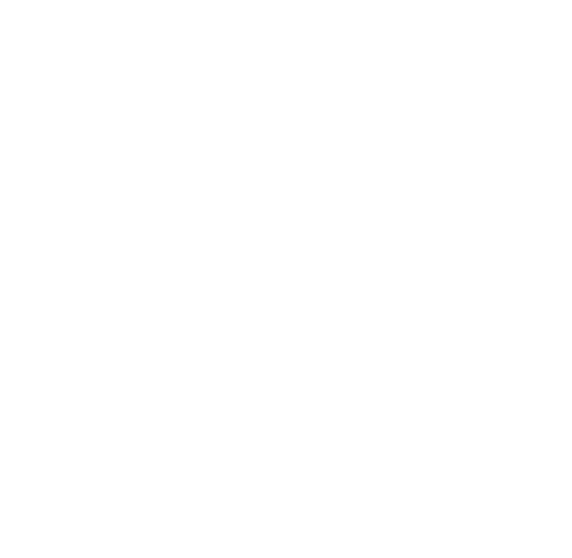

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
       # plt.imshow(images[i].numpy().astype("uint8"))
       # plt.title(int(labels[i]))
        plt.axis("off")

In [ ]:

data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

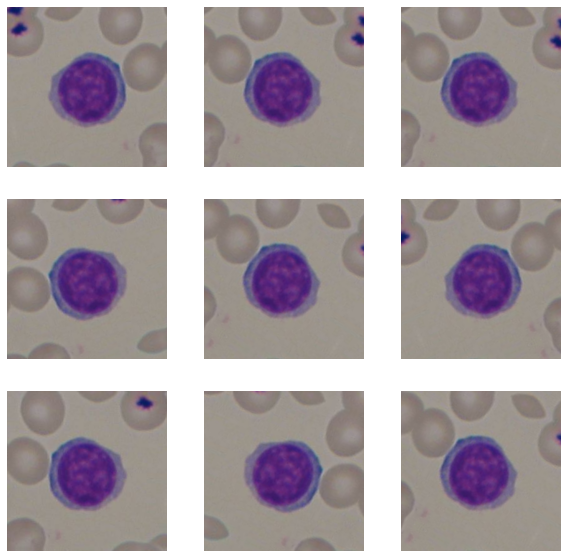

In [ ]:

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")


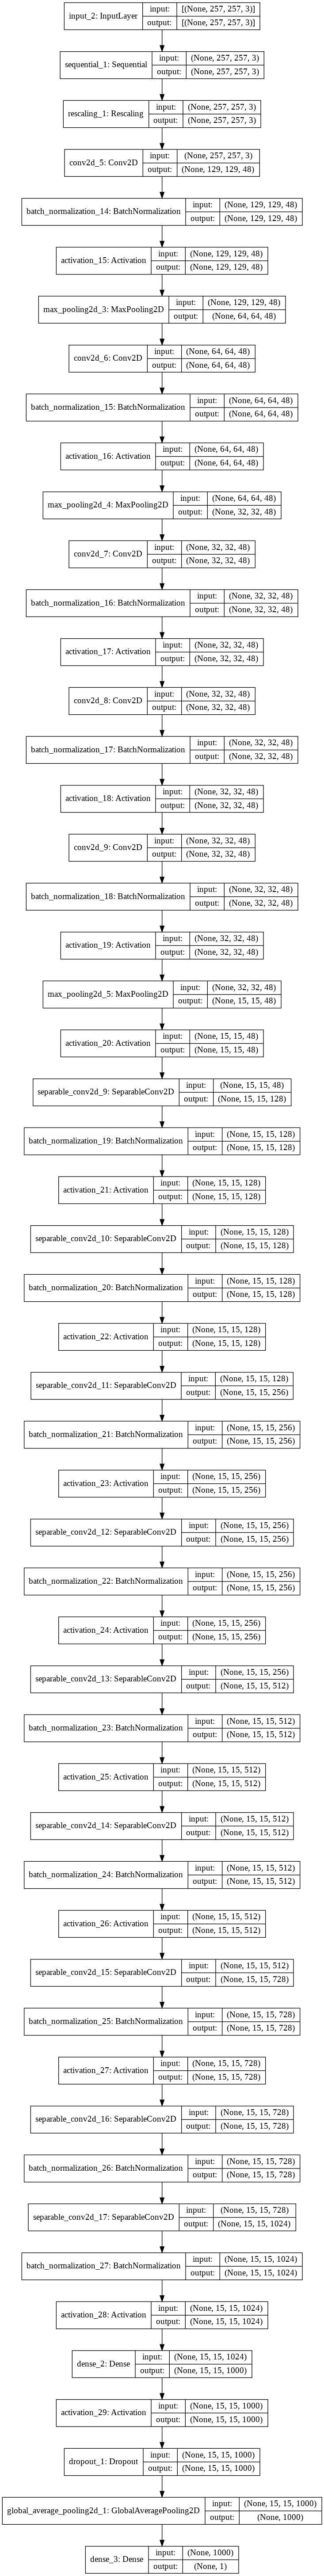

In [ ]:
def make_model(input_shape, num_classes):

    #x= keras.Input(shape=input_shape)
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(48, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPooling2D(2, strides=2, padding="valid")(x)

    x = layers.Conv2D(48, 3, strides=1, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPooling2D(2, strides=2, padding="valid")(x)

    
    x = layers.Conv2D(48, 5, strides=1, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
  
    
    x = layers.Conv2D(48, 3, strides=1, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    
    
    x = layers.Conv2D(48, 3, strides=1, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPooling2D(3, strides=2, padding="valid")(x)

    







    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        

        # Project residual
        #residual = layers.Conv2D(size, 1, strides=2, padding="same")(
         #   previous_block_activation
        #)
        #x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)



  
    x = layers.Dense(1000, activation="relu")(x)
    x = layers.Activation("relu")(x)
    x = layers.Dropout(0.5)(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)
  
model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
def recall(y_true, y_pred):
    y_true = K.ones_like(y_true) 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    all_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    
    recall = true_positives / (all_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    y_true = K.ones_like(y_true) 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_score(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
!pip install keras-metrics

model.compile(optimizer="sgd",
              loss="binary_crossentropy",
              metrics=[keras.metrics.Precision(), keras.metrics.Recall()])

In [ ]:




epochs = 500

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy", keras.metrics.Precision(), keras.metrics.Recall()],
)
amir=model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/500
3/3 [==============================] - 45s 11s/step - loss: 0.6844 - accuracy: 0.6394 - precision_3: 0.5986 - recall_3: 0.8462 - val_loss: 0.6933 - val_accuracy: 0.5000 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00
Epoch 2/500
3/3 [==============================] - 41s 11s/step - loss: 0.5488 - accuracy: 0.7740 - precision_3: 0.9524 - recall_3: 0.5769 - val_loss: 0.6932 - val_accuracy: 0.5000 - val_precision_3: 0.5000 - val_recall_3: 1.0000
Epoch 3/500
3/3 [==============================] - 42s 11s/step - loss: 0.7092 - accuracy: 0.6731 - precision_3: 0.6200 - recall_3: 0.8942 - val_loss: 0.6931 - val_accuracy: 0.5000 - val_precision_3: 0.5000 - val_recall_3: 1.0000
Epoch 4/500
3/3 [==============================] - 41s 11s/step - loss: 0.4949 - accuracy: 0.7788 - precision_3: 0.8372 - recall_3: 0.6923 - val_loss: 0.6931 - val_accuracy: 0.5000 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00
Epoch 5/500
3/3 [==============================] - 39s 11s/step 

Accuracy is: 0.9777980769872665


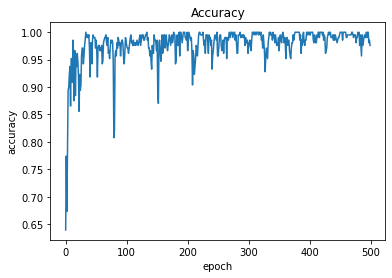

In [ ]:

amir.history['accuracy']
print("Accuracy is:" ,  np.mean(amir.history['accuracy']))

from matplotlib import pyplot
pyplot.plot(amir.history['accuracy'])
pyplot.title("Accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
pyplot.show()




precision is: 0.9823049236536026


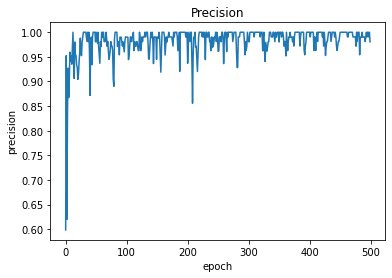

In [ ]:

amir.history['precision_3']
print("precision is:" ,  np.mean(amir.history['precision_3']))

pyplot.plot(amir.history["precision_3"])
pyplot.title("Precision")
plt.ylabel("precision")
plt.xlabel("epoch")
pyplot.show()

recall is: 0.9740576939582825


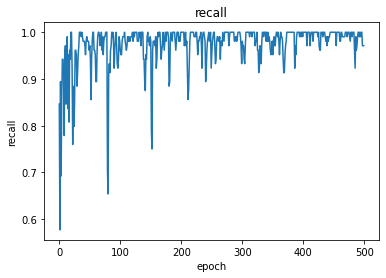

In [ ]:


amir.history['recall_3']
print("recall is:" ,  np.mean(amir.history['recall_3']))

pyplot.plot(amir.history["recall_3"])
pyplot.title("recall")
plt.ylabel("recall")
plt.xlabel("epoch")
pyplot.show()




loss is: 0.06670866909110919


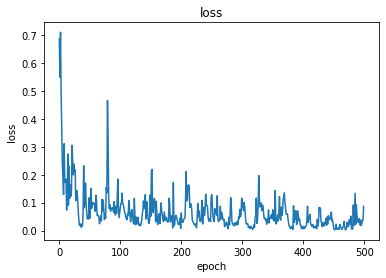

In [ ]:
amir.history['loss']
print("loss is:" ,  np.mean(amir.history['loss']))

pyplot.plot(amir.history["loss"])
pyplot.title("loss")
plt.ylabel("loss")
plt.xlabel("epoch")
pyplot.show()


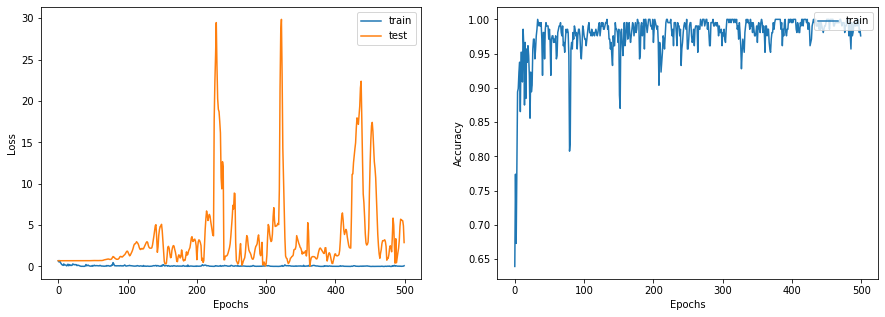

In [ ]:
def display_learning_curves(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(history.history["loss"])
    ax1.plot(history.history["val_loss"])
    ax1.legend(["train", "test"], loc="upper right")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")

    ax2.plot(history.history["accuracy"])
    #ax2.plot(history.history["val_acc"])
    ax2.legend(["train", "test"], loc="upper right")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Accuracy")
    plt.show()





display_learning_curves(amir)

In [ ]:
img = keras.preprocessing.image.load_img(
    "/content/gdrive/My Drive/Colab Notebooks/Image Processing/HW3/Cat/Im260_0.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent Normal(healthy) and %.2f percent Abnormal(not healthy)."
    % (100 * (1 - score), 100 * score)
)

This image is 99.92 percent Normal(healthy) and 0.08 percent Abnormal(not healthy).


In [ ]:
from keras import preprocessing

img = keras.preprocessing.image.load_img(
    "/content/gdrive/My Drive/Colab Notebooks/Image Processing/HW3/Dog/Im059_1.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent Normal(healthy) and %.2f percent Abnormal(not healthy)."
    % (100 * (1 - score), 100 * score)
)

This image is 0.00 percent Normal(healthy) and 100.00 percent Abnormal(not healthy).
